In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np 
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [2]:
from gym.spaces import Box
from gym import Wrapper, ObservationWrapper
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

class CustomWrapper(Wrapper):
    def reset(self, **kwargs):
        kwargs.pop('seed', None)  # Remove the 'seed' argument
        kwargs.pop('options', None)  # Remove the 'options' argument
        return self.env.reset(**kwargs)

# Wrap your environment
env = CustomWrapper(env)

class SkipFrame(Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info

    
class RemoveChannelDim(ObservationWrapper):
    def observation(self, observation):
        return np.squeeze(observation)
    
# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = RemoveChannelDim(env)
env = FrameStack(env, num_stack=4)


In [3]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import os

2023-06-12 23:29:13.986891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:29:14.932194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './dqn/train/'
LOG_DIR = './dqn/logs/'

In [6]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [7]:
import torch as th
import torch.nn as nn
from gymnasium import spaces

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(3136, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, features_dim))
            #nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)


In [8]:
model = DQN('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00001, 
            policy_kwargs=policy_kwargs, buffer_size=80000) 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [9]:
from stable_baselines3.common.logger import configure

def train_model():
    env.reset()
    new_logger = configure(LOG_DIR, ["stdout", "csv"])
    # Set new logger 
    model.set_logger(new_logger)

    model.learn(total_timesteps=100000, callback=callback)

#train_model()

In [10]:
model.save('dqn_test_model')

In [11]:
#env.close()

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy

model = DQN.load("dqn/train/best_model_100000")
obs = env.reset()

print(evaluate_policy(model, env, n_eval_episodes=10, deterministic=False, render=True))

print("Done.")


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


(1025.8, 407.66451893683364)
Done.


In [13]:
env.close()

In [14]:
import pandas as pd

df = pd.read_csv("ppo/logs/progress.csv")
df

,time/iterations,time/total_timesteps,time/fps,time/time_elapsed,rollout/ep_len_mean,train/n_updates,train/clip_range,train/value_loss,train/approx_kl,train/policy_gradient_loss,rollout/ep_rew_mean,train/loss,train/clip_fraction,train/explained_variance,train/learning_rate,train/entropy_loss
0,1,512,34,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1024,32,31,484.000000,10.0,0.2,3084.810617,8.731149e-09,-1.553334e-05,1281.00,1421.213867,0.0,-4.076958e-05,0.000001,-1.945910
2,3,1536,31,48,481.333333,20.0,0.2,4468.813751,0.000000e+00,-3.596878e-06,1186.00,2277.874512,0.0,-6.294250e-05,0.000001,-1.945910
3,4,2048,30,66,407.250000,30.0,0.2,3360.281651,0.000000e+00,-9.757816e-07,1154.75,2678.305420,0.0,-4.827976e-05,0.000001,-1.945910
4,5,2560,30,84,483.400000,40.0,0.2,4447.252802,3.608875e-09,-7.586245e-06,1207.40,2405.885742,0.0,-3.993511e-05,0.000001,-1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,4880,2498560,35,70509,587.550000,48790.0,0.2,2960.247899,0.000000e+00,-6.572483e-06,1845.34,1114.702148,0.0,0.000000e+00,0.000001,-1.910811
4880,4881,2499072,35,70524,581.720000,48800.0,0.2,2782.975160,0.000000e+00,-3.674690e-06,1839.15,1674.340576,0.0,0.000000e+00,0.000001,-1.910796
4881,4882,2499584,35,70540,571.240000,48810.0,0.2,8646.474963,0.000000e+00,-1.811481e-06,1830.29,5341.561035,0.0,0.000000e+00,0.000001,-1.910795
4882,4883,2500096,35,70556,566.980000,48820.0,0.2,4487.216092,0.000000e+00,-4.049699e-06,1813.86,1717.684814,0.0,-1.192093e-07,0.000001,-1.910790


In [15]:
df = df.fillna(0)
df

,time/iterations,time/total_timesteps,time/fps,time/time_elapsed,rollout/ep_len_mean,train/n_updates,train/clip_range,train/value_loss,train/approx_kl,train/policy_gradient_loss,rollout/ep_rew_mean,train/loss,train/clip_fraction,train/explained_variance,train/learning_rate,train/entropy_loss
0,1,512,34,14,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.00,0.000000,0.0,0.000000e+00,0.000000,0.000000
1,2,1024,32,31,484.000000,10.0,0.2,3084.810617,8.731149e-09,-1.553334e-05,1281.00,1421.213867,0.0,-4.076958e-05,0.000001,-1.945910
2,3,1536,31,48,481.333333,20.0,0.2,4468.813751,0.000000e+00,-3.596878e-06,1186.00,2277.874512,0.0,-6.294250e-05,0.000001,-1.945910
3,4,2048,30,66,407.250000,30.0,0.2,3360.281651,0.000000e+00,-9.757816e-07,1154.75,2678.305420,0.0,-4.827976e-05,0.000001,-1.945910
4,5,2560,30,84,483.400000,40.0,0.2,4447.252802,3.608875e-09,-7.586245e-06,1207.40,2405.885742,0.0,-3.993511e-05,0.000001,-1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,4880,2498560,35,70509,587.550000,48790.0,0.2,2960.247899,0.000000e+00,-6.572483e-06,1845.34,1114.702148,0.0,0.000000e+00,0.000001,-1.910811
4880,4881,2499072,35,70524,581.720000,48800.0,0.2,2782.975160,0.000000e+00,-3.674690e-06,1839.15,1674.340576,0.0,0.000000e+00,0.000001,-1.910796
4881,4882,2499584,35,70540,571.240000,48810.0,0.2,8646.474963,0.000000e+00,-1.811481e-06,1830.29,5341.561035,0.0,0.000000e+00,0.000001,-1.910795
4882,4883,2500096,35,70556,566.980000,48820.0,0.2,4487.216092,0.000000e+00,-4.049699e-06,1813.86,1717.684814,0.0,-1.192093e-07,0.000001,-1.910790


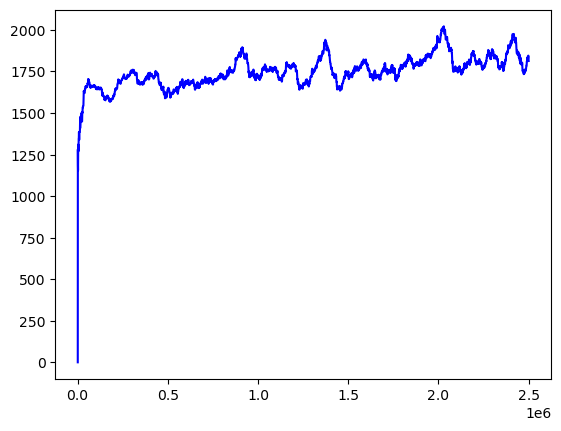

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
xpoints = np.array(df['time/total_timesteps'].to_numpy())
ypoints = np.array(df['rollout/ep_rew_mean'].to_numpy())
plt.plot(xpoints, ypoints, color = 'b')
plt.show()
plt.savefig('dqn/plots/mean_reward.png')
plt.clf()

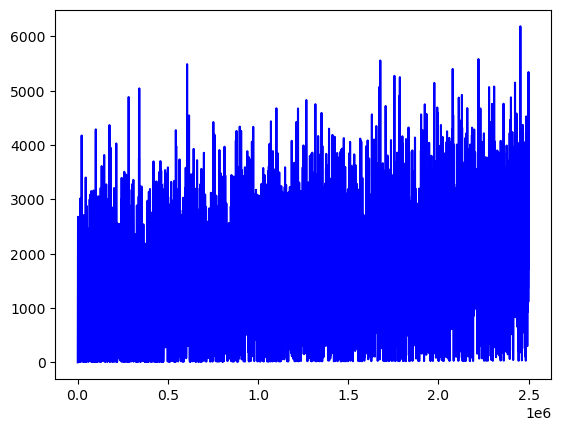

<Figure size 640x480 with 0 Axes>

In [17]:
xpoints = np.array(df['time/total_timesteps'].to_numpy())
ypoints = np.array(df['train/loss'].to_numpy())
plt.plot(xpoints, ypoints, color = 'b')
plt.show()
plt.savefig('dqn/plots/loss.png')
plt.clf()

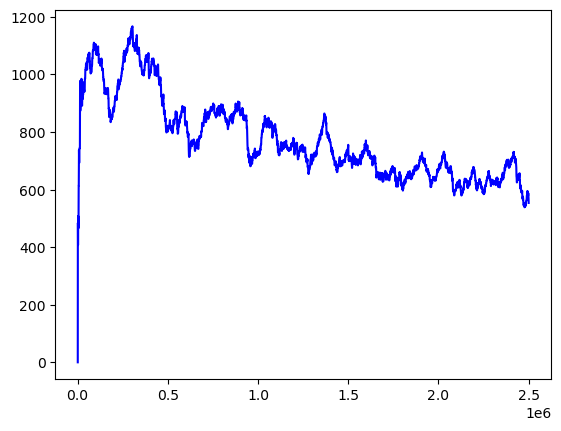

<Figure size 640x480 with 0 Axes>

In [18]:
xpoints_len = np.array(df['time/total_timesteps'].to_numpy())
ypoints_len = np.array(df['rollout/ep_len_mean'].to_numpy())
plt.plot(xpoints_len, ypoints_len, color = 'b')
plt.show()
plt.savefig('dqn/plots/length.png')
plt.clf()